In [58]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

from utils import plot_results

# Project: One-Mass Oscillator Optimization

## Introduction

In this project, various optimization algorithms will be applied to fit a one-mass oscillator model to real-world data. The objective is to minimize the sum of the squared residuals between the model predictions and the observed amplitudes of a one-mass oscillator system across different frequencies.

### One-Mass Oscillator Model

The one-mass oscillator is characterized by the following equation, representing the amplitudes of the system:

$$ V(\omega) = \frac{F}{\sqrt{(1 - \nu^2)^2 + 4D^2\nu^2}} $$

Here, 
- $ \omega $ represents the angular frequency of the system,
- $ \nu $ is the ratio of the excitation frequency to the natural frequency ($ \nu = \frac{\omega_{\text{err}}}{\omega_{\text{eig}}} $),
- $ D $ is the damping ratio,
- $ F $ is the force applied to the system.

The goal of the project is to determine the optimal values for the parameters $ \omega_{\text{eig}} $, $ D $, and $ F $ that result in the best fit of the one-mass oscillator model to the observed amplitudes.

### Load the real world data

- we have two different measurements
- J represents the measured frequencies
- N represents the measured amplitudes

In [9]:
df1 = pd.read_pickle("./data/df1.pkl")
df2 = pd.read_pickle("./data/df2.pkl")

### Low amplitudes distort the fit and are negligible therefore we define a lower threshold for N

In [10]:
# Define maximum threshold for removing low amplitudes
max_threshold = 0.4 * max(df1["N"])

# Remove the low amplitude entries to avoid distortion in fitting
df1 = df1[df1["N"]>=max_threshold]
df2 = df2[df2["N"]>=max_threshold]

### We extract the frequency value for maximum value of the amplitude. This serves as the initial value for one decision variable

In [31]:
df1_max = df1[df1["N"]==max(df1["N"])]
df1_initial_eig = df1_max["J"].values[0]
df1_max_N = df1_max["N"].values[0]

df2_max = df2[df2["N"]==max(df2["N"])]
df2_initial_eig = df2_max["J"].values[0]
df2_max_N = df2_max["N"].values[0]

### We also have to define the other two initial guesses

In [12]:
# Initial guesses of force and damping ratio values
initial_D = 0.006
initial_F = 0.120

df1_initial_values = [df1_initial_eig, initial_D, initial_F]
df2_initial_values = [df2_initial_eig, initial_D, initial_F]

### Additionally we define the bounds for the decision variables

In [13]:
# Define minimum and maximum frequency values for boundary condition
df1_min_J = min(df1["J"])
df1_max_J = max(df1["J"])

df2_min_J = min(df2["J"])
df2_max_J = max(df2["J"])

In [14]:
df1_bounds = [(df1_min_J, df1_max_J), (0, 0.03), (0, 1)]
df2_bounds = [(df2_min_J, df2_max_J), (0, 0.03), (0, 1)]

### Then we define our one mass oscialltor and objective function

In [21]:
def one_mass_oscillator(params, J) -> np.ndarray:
    # returns amplitudes of the system
    # Defines the model of a one mass oscilator 
    eig, D, F = params
    nue = J / eig
    V = F / (np.sqrt((1 - nue**2) ** 2 + (4 * D**2 * nue**2)))
    return V

In [22]:
def objective_function(params, J, N) -> np.ndarray:
    # sum of squared errors to compare calculated and real amplitudes
    return np.sum((N - one_mass_oscillator(params, J)) ** 2)

### Define gradient function of objective function for optimizers that require gradient matrix 

In [16]:
def gradient(params, J, N):
    eig, D, F = params
    nue = J / eig

    u = (1 - nue**2) ** 2 + (4 * D**2 * nue**2)
    dfdF = np.sum(-2 / np.sqrt(u))
    dfdD = np.sum((8 * F * D * nue**2) / (np.sqrt(u ** 3)))
    dfdeig = np.sum((4 * (nue**2 - nue**4 - 2 * nue**2 * D**2)) / (eig * np.sqrt(u ** 3)))

    return np.array([dfdF, dfdD, dfdeig])

### Define hessian function of objective function for optimizers that require hessian matrix 

In [17]:
def hessian(params, J, N):
    eig, D, F = params
    nue = J / eig

    u = (1 - nue**2) ** 2 + (4 * D**2 * nue**2)
    du = (nue**2 - nue**4 - 2 * nue**2 * D**2)
    d2fdF = 0
    d2fdFD = np.sum((8 * D * nue**2) / (np.sqrt(u ** 3)))
    d2fdFeig = np.sum((4 * du) / (eig * np.sqrt(u ** 3)))
    d2fdDF = d2fdFD
    d2fdD = np.sum(8 * nue**2 * F - ((192 * D**2 * nue**4 * F) / u))
    d2fdDeig = np.sum((16 * F * D * nue**2 / eig) * (-1 - (6 * du) / u))
    d2fdeigF = d2fdFeig
    d2fdeigD = d2fdDeig
    d2fdeig = np.sum(((20 * nue**4 - 12 * nue**2 + 24 * nue**2 * D**2) / eig**2)  - ((48 * du ** 2) / (eig * u)))

    return np.array([[d2fdF, d2fdFD, d2fdFeig],[d2fdDF, d2fdD, d2fdDeig],[d2fdeigF, d2fdeigD, d2fdeig]])

### Extract the frequency and amplitude from the dataframes

In [18]:
df1_J = np.array(df1["J"])
df1_N = np.array(df1["N"])

df2_J = np.array(df2["J"])
df2_N = np.array(df2["N"])

### Generate the frequencies to fit the one mass oscillator

In [35]:
df1_J_pred = np.linspace(df1_min_J, df1_max_J, 1000)
df2_J_pred = np.linspace(df2_min_J, df2_max_J, 1000)

### Define the options and start the optimizations (Nelder-Mead)

In [36]:
options = {
    "maxiter": 100000,
    "fatol": 1e-9,
    "xatol": 1e-9,
}

df1_result = minimize(objective_function, df1_initial_values, args=(df1_J, df1_N), method='Nelder-Mead', bounds=df1_bounds, options=options)
df2_result = minimize(objective_function, df2_initial_values, args=(df2_J, df2_N), method='Nelder-Mead', bounds=df2_bounds, options=options)

In [41]:
df1_resonant_frequency = df1_result.x[0]
df1_D = df1_result.x[1]
df1_F = df1_result.x[2]

# predict the resonant amplitude with the fitted one mass oscillator.
df1_one_mass_oscillator = one_mass_oscillator(df1_result.x, df1_J_pred)
df1_resonant_amplitude = max(df1_one_mass_oscillator)

df2_resonant_frequency = df2_result.x[0]
df2_D = df2_result.x[1]
df2_F = df2_result.x[2]

# predict the resonant amplitude with the fitted one mass oscillator.
df2_one_mass_oscillator = one_mass_oscillator(df2_result.x, df2_J_pred)
df2_resonant_amplitude = max(df2_one_mass_oscillator)

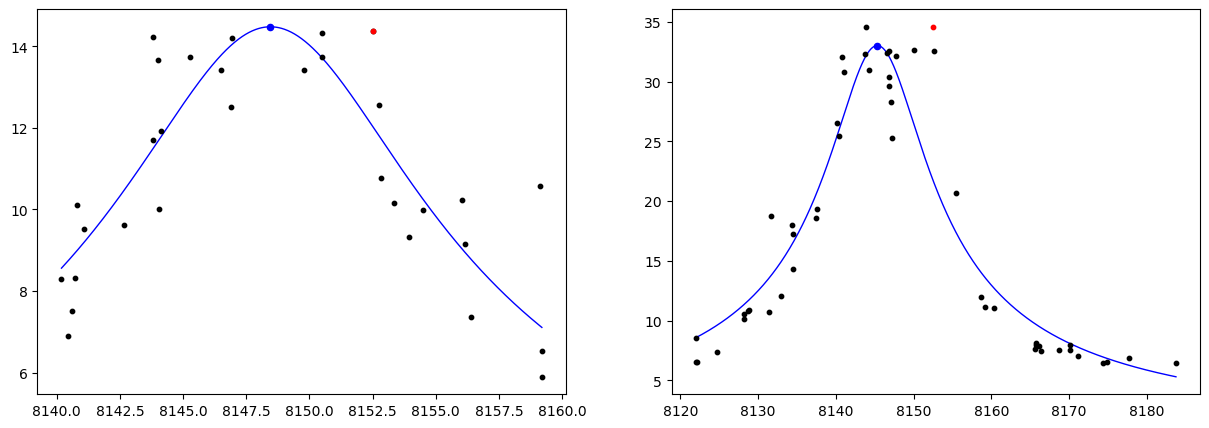

In [59]:
plot_results(
    [df1,df2], 
    [df1_initial_eig, df1_initial_eig], 
    [df1_max_N, df2_max_N], 
    [df1_J_pred, df2_J_pred], 
    [df1_one_mass_oscillator, df2_one_mass_oscillator],
    [df1_resonant_frequency, df2_resonant_frequency],
    [df1_resonant_amplitude, df2_resonant_amplitude]
)

In [33]:
# Think about how to implement other optimizers without repeating  the same thing (ex: extract the argumnts as dictionary to another file)
# - Nelder-Mead
# - Powell
# - Differential Evolution
# - Simulated Annealing
# - BFGS
# - Newton-CG
# - CG
# options = {
#         "Powell": {
#             "disp": True,
#             "maxiter": 100000,
#             "ftol": 1e-9,
#             "xtol": 1e-9,
#         },
#         "CG": {
#             "disp": True,
#             "maxiter": 100000,
#             "gtol": 1e-9,
#         }, 
#         "BFGS": {
#             "disp": True,
#             "maxiter": 100000,
#             "gtol": 1e-9,
#         }, 
#         "Newton-CG": {
#             "disp": True,
#             "maxiter": 100000,
#             "xtol": 1e-9,
#         }, 
#     }
# ypred_one_mass_oscillator = one_mass_oscillator(result.x, X_pred)
# resonant_amplitude = max(ypred_one_mass_oscillator)
# Get the results of the optimizers
# Generate the data using the results
# Plot the results